In [1]:
!pip install -q mediapipe

In [2]:
import numpy as np
from PIL import Image
import requests
import io
import cv2
import mediapipe as mp
import math
import matplotlib.pyplot as plt

/Users/rafaelrnzo/anaconda3/envs/envAI/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Skin Tone Detection (Cheek only)

In [ ]:
SKIN_PALETTE = {
    "Winter": (241, 212, 202),
    "Summer": (240, 201, 183),
    "Spring": (255, 224, 196),
    "Autumn": (234, 193, 153)
}

In [4]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  min_detection_confidence=0.5)

I0000 00:00:1754596010.883298  239357 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


W0000 00:00:1754596010.886975  239964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754596010.890849  239964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
image_url = "https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg"
image = None

try:
    response = requests.get(image_url)
    response.raise_for_status()
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("Image not found. Please check the file path.")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
except FileNotFoundError as e:
    print(e)

W0000 00:00:1754596016.879270  239964 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [ ]:
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        left_cheek_indices = [118, 119, 148, 138, 135, 213]
        right_cheek_indices = [347, 348, 377, 367, 364, 433]

        left_cheek_points = []
        for index in left_cheek_indices:
            x = int(face_landmarks.landmark[index].x * image.shape[1])
            y = int(face_landmarks.landmark[index].y * image.shape[0])
            left_cheek_points.append([x, y])

        right_cheek_points = []
        for index in right_cheek_indices:
            x = int(face_landmarks.landmark[index].x * image.shape[1])
            y = int(face_landmarks.landmark[index].y * image.shape[0])
            right_cheek_points.append([x, y])

In [7]:
mask = np.zeros(image.shape[:2], dtype=np.uint8)

cv2.fillPoly(mask, [np.array(left_cheek_points)], (255))
cv2.fillPoly(mask, [np.array(right_cheek_points)], (255))

mean_color = cv2.mean(image, mask=mask)

face_mesh.close()
print(f"Average cheek color (BGR): {mean_color[:3]}")

Average cheek color (BGR): (171.41557453609053, 178.49512049606375, 212.55820359410012)


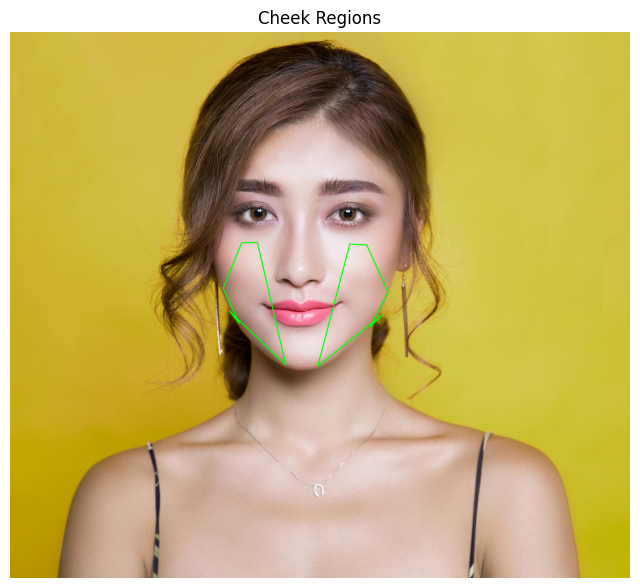

In [17]:
image_result = image.copy()
cv2.polylines(image_result, [np.array(left_cheek_points)], isClosed=True, color=(0, 255, 0), thickness=10)
cv2.polylines(image_result, [np.array(right_cheek_points)], isClosed=True, color=(0, 255, 0), thickness=10)

# Convert the final image (with drawings) from BGR to RGB for matplotlib
img_result_rgb = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Display the image using matplotlib
plt.figure(figsize=(8, 8)) # You can adjust the figure size
plt.imshow(img_result_rgb)
plt.title('Cheek Regions')
plt.axis('off') # Hide the axes
plt.show()

# Other skin detection

In [8]:
def detect_skin(image_path):
    # Initialize mediapipe
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    
    try:
        if image_path.startswith(('http://', 'https://')):
            response = requests.get(image_path)
            response.raise_for_status()
            image_file = io.BytesIO(response.content)
            original_image_pil = Image.open(image_file).convert('RGB')
        else:
            original_image_pil = Image.open(image_path).convert('RGB')
        original_image_cv = np.array(original_image_pil)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None, None, False

    results = face_detection.process(original_image_cv)

    if not results.detections:
        print("No face detected in the image.")
        return 0, None, original_image_pil, False, original_image_pil

    # First detected space
    detection = results.detections[0]
    bboxC = detection.location_data.relative_bounding_box
    ih, iw, _ = original_image_cv.shape
    x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                 int(bboxC.width * iw), int(bboxC.height * ih)

    padding = 20
    x, y = max(0, x - padding), max(0, y - padding)
    w, h = w + (padding * 2), h + (padding * 2)
    face_image_cv = original_image_cv[y:y+h, x:x+w]
    face_image_pil = Image.fromarray(face_image_cv)

    np_face = np.array(face_image_pil)
    ycbcr_face = face_image_pil.convert('YCbCr')
    np_ycbcr_face = np.array(ycbcr_face, dtype=np.uint8)
    
    cb_min, cb_max = 85, 135
    cr_min, cr_max = 135, 180

    Cb = np_ycbcr_face[:, :, 1]
    Cr = np_ycbcr_face[:, :, 2]

    skin_mask_matrix = (Cb >= cb_min) & (Cb <= cb_max) & (Cr >= cr_min) & (Cr <= cr_max)

    total_face_pixels = face_image_pil.width * face_image_pil.height
    skin_pixels_in_face = np.sum(skin_mask_matrix)
    skin_percentage_in_face = (skin_pixels_in_face / total_face_pixels) * 100

    average_rgb = None
    if skin_pixels_in_face > 0:
        skin_rgb_pixels = np_face[skin_mask_matrix]
        avg_color_float = np.mean(skin_rgb_pixels, axis=0)
        average_rgb = tuple(avg_color_float.astype(int))

    skin_on_face = np.zeros_like(np_face)
    # Use the mask to copy skin pixels from the face crop
    skin_on_face[skin_mask_matrix] = np_face[skin_mask_matrix]
    
    # Place this result back onto the original image
    result_image_cv = original_image_cv.copy()
    # Draw a bounding box around the detected face
    cv2.rectangle(result_image_cv, (x, y), (x+w, y+h), (0, 255, 0), 20)
    # Paste the skin mask result into the box
    # Ensure the paste area doesn't exceed the original image boundaries
    paste_h, paste_w, _ = skin_on_face.shape
    result_image_cv[y:y+paste_h, x:x+paste_w] = skin_on_face
    
    result_image_pil = Image.fromarray(result_image_cv)
    
    face_detection.close()

    return skin_percentage_in_face, average_rgb, result_image_pil, True, original_image_pil

In [9]:
def plot_result(original_image_pil, result_img, avg_rgb):
    category = categorize_color(avg_rgb, SKIN_PALETTE)
    print(f"Detected color belongs to: {category}")

    # PLOTTING THE RESULTS
    color_img = Image.new("RGB", (200, 200), avg_rgb)
    category_img = Image.new("RGB", (200, 200), SKIN_PALETTE[category])
    image_array = original_image_pil.resize((200, 200))
    result_img = result_img.resize((200, 200))

    color_arr = np.array(color_img)
    category_arr = np.array(category_img)
    image_array = np.array(image_array)
    result_img = np.array(result_img)

    fig, axes = plt.subplots(2, 2, figsize=(9, 9))

    axes[0][0].imshow(image_array)
    axes[0][0].set_title("Original Image")
    axes[0][0].axis("off")
    
    axes[0][1].imshow(color_arr)
    axes[0][1].set_title("Average RGB")
    axes[0][1].axis("off")
    
    axes[1][0].imshow(result_img)
    axes[1][0].set_title("Detected Face")
    axes[1][0].axis("off")
    
    axes[1][1].imshow(category_arr)
    axes[1][1].set_title(f"Category: {category}")
    axes[1][1].axis("off")
    
    plt.tight_layout()
    plt.savefig('Skin detection result.png')
    plt.show()

def color_distance(rgb1, rgb2):
    """
    Calculates the Euclidean distance between two RGB colors.
    """
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2
    return math.sqrt((r1 - r2)**2 + (g1 - g2)**2 + (b1 - b2)**2)

def categorize_color(detected_rgb, color_palette):
    """
    Finds the closest color category from a palette for a given RGB color.

    Args:
        detected_rgb (tuple): The (R, G, B) color that was detected.
        color_palette (dict): A dictionary where keys are category names (e.g., "Winter")
                              and values are reference (R, G, B) tuples.

    Returns:
        str: The name of the closest color category.
    """
    closest_category = None
    min_distance = float('inf')

    for category, reference_rgb in color_palette.items():
        distance = color_distance(detected_rgb, reference_rgb)
        
        if distance < min_distance:
            min_distance = distance
            closest_category = category
            
    return closest_category

Processing image from: https://images.squarespace-cdn.com/content/v1/5ad032f6cc8fed72fd13934a/1555654889591-JYBQW3DFSOZ6K5M3X3EJ/ABC.jpg?format=500w



I0000 00:00:1754598360.128054  239357 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1754598360.147000  310267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Face detected!
Percentage of skin in face region: 67.72%
Average Face Skin Tone (RGB): (203, 158, 150)
Detected color belongs to: Autumn


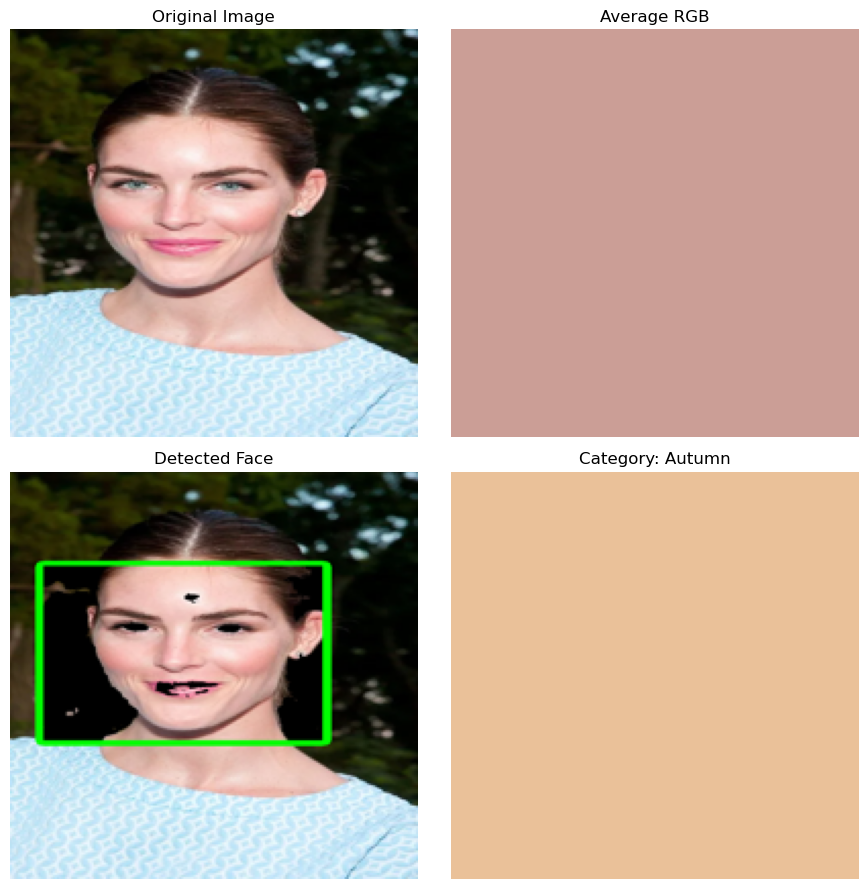

In [ ]:
# IMAGE_SOURCE = "https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg"
# IMAGE_SOURCE = "https://images.pexels.com/photos/794064/pexels-photo-794064.jpeg"
# IMAGE_SOURCE = "https://images.pexels.com/photos/4519118/pexels-photo-4519118.jpeg"
# IMAGE_SOURCE = "https://images.pexels.com/photos/5273717/pexels-photo-5273717.jpeg"
# IMAGE_SOURCE = "https://images.pexels.com/photos/29986160/pexels-photo-29986160.png"
IMAGE_SOURCE = "https://images.squarespace-cdn.com/content/v1/5ad032f6cc8fed72fd13934a/1555658431345-L73NMBIE438KAS57YW54/ABC.jpg?format=500w"

print(f"Processing image from: {IMAGE_SOURCE}\n")

# Call the detection function
skin_perc, avg_rgb, result_img, face_found, original_img = detect_skin(IMAGE_SOURCE)

if face_found:
    print(f"Face detected!")
    print(f"Percentage of skin in face region: {skin_perc:.2f}%")
    
    if avg_rgb:
        print(f"Average Face Skin Tone (RGB): {avg_rgb}")
        plot_result(original_img, result_img, avg_rgb)
    
    # Save the output image
    # result_filename = "face_skin_detected_result.png"
    # result_img.save(result_filename)
    # print(f"\nSaved annotated result to: '{result_filename}'")
else:
    print("Could not find a face in the image to analyze.")

# color_img.show()
# category_img.show()

# Eye Color Detection

In [14]:
def detect_eye_color(image_path_or_url):
    """
    Detects eye color by isolating the irises using MediaPipe Face Mesh.
    This version corrects the color channel handling between libraries.

    Args:
        image_path_or_url (str): The local file path or URL of the image.

    Returns:
        dict: A dictionary containing the average RGB color for the left and
              right eye, and the annotated image. Returns None if no face
              or eyes are detected.
    """
    # --- 1. SETUP ---
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,  # Crucial for iris detection
        min_detection_confidence=0.5
    )

    LEFT_IRIS_INDICES = [473, 474, 475, 476, 477]
    RIGHT_IRIS_INDICES = [468, 469, 470, 471, 472]

    try:
        # --- 2. IMAGE LOADING (as RGB) ---
        if image_path_or_url.startswith(('http://', 'https://')):
            response = requests.get(image_path_or_url)
            response.raise_for_status()
            image_file = io.BytesIO(response.content)
            pil_image = Image.open(image_file).convert('RGB')
        else:
            pil_image = Image.open(image_path_or_url).convert('RGB')
        
        # Convert PIL (RGB) to NumPy array for processing
        image_rgb = np.array(pil_image)
        # Create a BGR version specifically for OpenCV drawing functions
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # --- 3. FACE AND IRIS DETECTION (using RGB image) ---
    results = face_mesh.process(image_rgb)
    
    # Annotations will be drawn on the BGR version
    annotated_image_bgr = image_bgr.copy()
    eye_colors = {}

    if not results.multi_face_landmarks:
        print("No face detected in the image.")
        face_mesh.close()
        return None

    face_landmarks = results.multi_face_landmarks[0].landmark
    image_h, image_w, _ = image_rgb.shape

    # --- 4. IRIS ISOLATION AND COLOR AVERAGING ---
    for eye_name, iris_indices in [('right', RIGHT_IRIS_INDICES), ('left', LEFT_IRIS_INDICES)]:
        
        iris_points = np.array(
            [(int(face_landmarks[i].x * image_w), int(face_landmarks[i].y * image_h)) for i in iris_indices]
        )

        center = np.mean(iris_points, axis=0).astype(int)
        radius = int(np.mean(np.linalg.norm(iris_points - center, axis=1))) + 2

        mask = np.zeros((image_h, image_w), dtype=np.uint8)
        cv2.circle(mask, tuple(center), radius, 255, -1)
        
        # --- 5. REMOVE REFLECTIONS ---
        x, y, w, h = cv2.boundingRect(iris_points)
        # Use the BGR image for color averaging with OpenCV
        eye_image_bgr = image_bgr[y:y+h, x:x+w]
        eye_mask = mask[y:y+h, x:x+w]
        
        # Convert BGR to grayscale for thresholding
        gray_eye = cv2.cvtColor(eye_image_bgr, cv2.COLOR_BGR2GRAY)
        _, reflection_mask = cv2.threshold(gray_eye, 220, 255, cv2.THRESH_BINARY)
        
        clean_mask = cv2.bitwise_and(eye_mask, cv2.bitwise_not(reflection_mask))

        if cv2.countNonZero(clean_mask) > 0:
            # cv2.mean works on BGR and returns a BGR tuple
            avg_bgr = cv2.mean(eye_image_bgr, mask=clean_mask)[:3]
            # Convert to RGB for returning the final value
            avg_rgb = (int(avg_bgr[2]), int(avg_bgr[1]), int(avg_bgr[0]))
            eye_colors[eye_name] = avg_rgb
            
            # --- 6. ANNOTATION (on BGR image with BGR colors) ---
            cv2.circle(annotated_image_bgr, tuple(center), radius, (0, 255, 0), 1)
            cv2.circle(annotated_image_bgr, tuple(center), 1, (0, 0, 255), -1)
            
            color_swatch_y = y - 10 if y > 30 else y + h + 20
            cv2.rectangle(annotated_image_bgr, (x, color_swatch_y - 15), (x + 100, color_swatch_y), avg_bgr, -1)
            cv2.putText(annotated_image_bgr, f"{eye_name.capitalize()}", (x, color_swatch_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    face_mesh.close()

    # --- 7. FINAL CONVERSION ---
    # Convert the annotated BGR image back to RGB before returning as a PIL Image
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    
    return {
        "colors": eye_colors,
        "annotated_image": Image.fromarray(annotated_image_rgb)
    }

In [12]:
IMAGE_SOURCE = "https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg"

print(f"Processing image from: {IMAGE_SOURCE}\n")

detection_result = detect_eye_color(IMAGE_SOURCE)

if detection_result and detection_result["colors"]:
    print("Eye Color Detection Results:")
    for eye, color in detection_result["colors"].items():
        print(f"  - Average color for {eye.capitalize()} Eye (RGB): {color}")
    
    # Save the annotated image
    output_filename = "eye_color_result.png"
    detection_result["annotated_image"].save(output_filename)
    print(f"\nSaved annotated image to '{output_filename}'")
    
else:
    print("Could not detect eye color. Please try another image with a clear, front-facing face.")

Processing image from: https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg



I0000 00:00:1754596059.102913  239357 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1754596059.105694  241116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754596059.116089  241113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Eye Color Detection Results:
  - Average color for Right Eye (RGB): (62, 49, 44)
  - Average color for Left Eye (RGB): (64, 52, 45)

Saved annotated image to 'eye_color_result.png'
